![image.png](https://avatars.mds.yandex.net/get-zen_doc/1362552/pub_5d62c34c2f4ad700ac2ed47f_5d62c3bba660d700ad2c37cd/scale_1200)

In [397]:
from pandas import Series
import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

import warnings
warnings.filterwarnings("ignore")

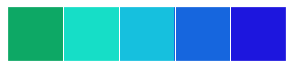

In [398]:
# установим цвета
colors = ['#0da865', '#16dec7', '#16c0de', '#1666de','#1d16de']
sns.palplot(sns.color_palette(colors))

In [399]:
# Функции

# Замена NaN
def missing_value(col):
    mask = col.isna()
    #считаем статистику распределения значений
    p = col.value_counts()/len(col.dropna())
    #заполняем пропуски с вероятностью p
    col.loc[mask]=np.random.choice(p.index.to_list(),
                                            size = mask.sum(), p=p.to_list()) 
    return(col)



def age_to_cat(age):
    if age <= 28:
        cat_age = 1 #'young'
        return cat_age             
    if 28 < age <= 35:
        cat_age = 2 #'not-young'
        return cat_age
    if 35 < age <= 50:
        cat_age = 3 #'midle'
        return cat_age
    if age > 50:
        cat_age = 4 #'oldfag'
        return cat_age

In [400]:
train = pd.read_csv("./train.csv", encoding='ISO-8859-1', low_memory=False)
test = pd.read_csv("./test.csv", encoding='ISO-8859-1', low_memory=False)

## Описания полей

client_id - идентификатор клиента

education - уровень образования

sex - пол заемщика

age - возраст заемщика

car - флаг наличия автомобиля

car_type - флаг автомобиля иномарки

decline_app_cnt - количество отказанных прошлых заявок

good_work - флаг наличия “хорошей” работы

bki_request_cnt - количество запросов в БКИ

home_address - категоризатор домашнего адреса

work_address - категоризатор рабочего адреса

income - доход заемщика

foreign_passport - наличие загранпаспорта

sna - связь заемщика с клиентами банка

first_time - давность наличия информации о заемщике

score_bki - скоринговый балл по данным из БКИ

region_rating - рейтинг региона

app_date - дата подачи заявки

default - флаг дефолта по кредиту

## Посмотрим на данные

In [401]:
train.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


In [402]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

Посмотрим на пропущенные значения

<AxesSubplot:>

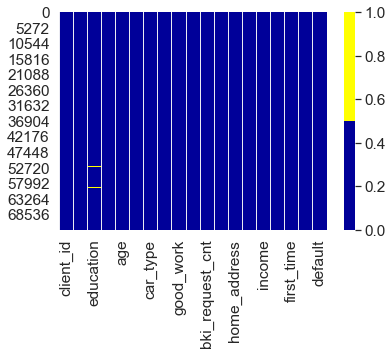

In [403]:
# тепловая карта пропущенных значений
cols = train.columns[:]
# определяем цвета
# желтый - пропущенные данные, синий - не пропущенные
colours = ['#000099', '#ffff00']
sns.heatmap(train[cols].isnull(), cmap=sns.color_palette(colours))

In [404]:
test.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N


In [405]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

<AxesSubplot:>

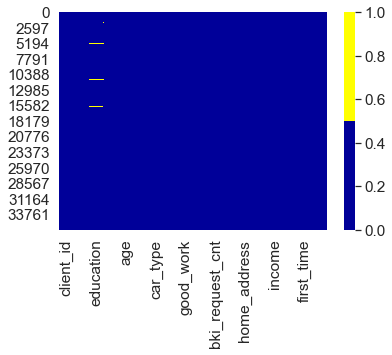

In [406]:
# тепловая карта пропущенных значений
cols = test.columns[:] 
# определяем цвета 
# желтый - пропущенные данные, синий - не пропущенные
colours = ['#000099', '#ffff00'] 
sns.heatmap(test[cols].isnull(), cmap=sns.color_palette(colours))

В обоих датасетах присутсвуют пропуски в признаке 'education'

Посмотрим на распределение признака 'education'

<AxesSubplot:xlabel='education', ylabel='count'>

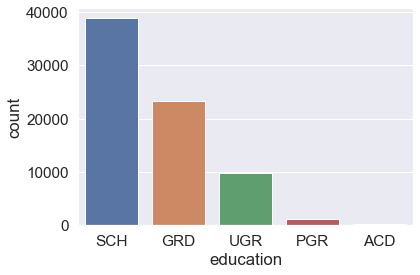

In [407]:
sns.countplot(train['education'])

<AxesSubplot:xlabel='education', ylabel='count'>

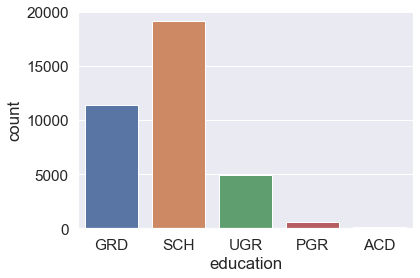

In [408]:
sns.countplot(test['education'])

Заполним пропуски

In [409]:
train['education'] = missing_value(train['education'])
test['education'] = missing_value(test['education'])

## Предобработка данных

Выделим столбцы по типу признаков

In [410]:
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

cat_cols = ['education', 'home_address', 'work_address', 'sna', 'first_time']

num_cols = ['age', 'decline_app_cnt', 'region_rating',
            'income', 'bki_request_cnt', 'score_bki']

Закодируем бинарные признаки. Для бинарных признаков мы будем использовать LabelEncoder.

In [411]:
label_encoder = LabelEncoder()

for column in bin_cols:
    train[column] = label_encoder.fit_transform(train[column])
    test[column] = label_encoder.fit_transform(test[column])

Убедимся в преобразовании  

In [412]:
train.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,1,62,1,1,0,0,-2.008753,1,50,1,2,18000,4,1,0,0
1,63161,12MAR2014,SCH,0,59,0,0,0,0,-1.532276,3,50,2,3,19000,4,1,0,0
2,25887,01FEB2014,SCH,1,25,1,0,2,0,-1.408142,1,80,1,2,30000,1,4,1,0
3,16222,23JAN2014,SCH,0,53,0,0,0,0,-2.057471,2,50,2,3,10000,1,3,0,0
4,101655,18APR2014,GRD,1,48,0,0,0,1,-1.244723,1,60,2,3,30000,1,4,1,0


In [413]:
test.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,1,29,1,1,0,0,-2.271884,3,50,1,2,50000,1,4,0
1,17527,24JAN2014,SCH,0,39,0,0,5,0,-1.504999,2,50,1,2,5000,4,3,0
2,75683,23MAR2014,UGR,1,50,1,1,0,0,-1.691339,1,50,1,2,30000,1,3,1
3,26883,03FEB2014,SCH,1,56,0,0,0,0,-2.374182,1,40,1,2,17000,1,3,0
4,28862,04FEB2014,GRD,0,38,0,0,0,0,-2.487502,0,80,2,3,120000,1,3,0


Посмотрим на матрицу корреляций в бинарных признаках

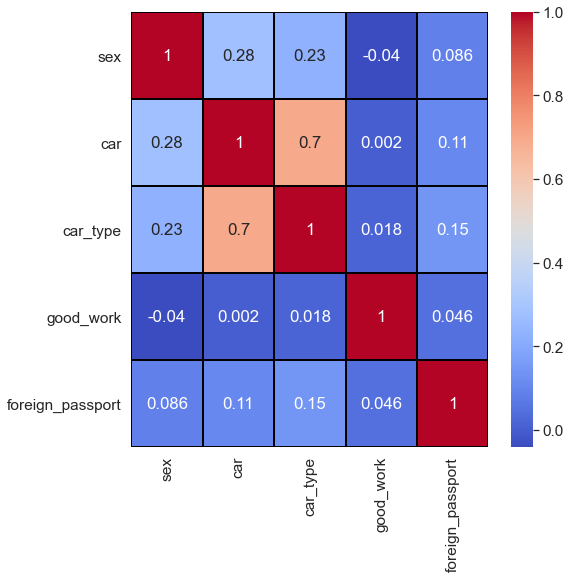

In [414]:
sns.heatmap(train[bin_cols].corr(),annot = True, cmap = 'coolwarm',
            linewidths=1, linecolor='black')
fig = plt.gcf()
fig.set_size_inches(8,8)

Наблюдаем высокую корреляцию между признаками car и car_type. Попробуем в дальнейшем сгенерировать из них один признак.

### Посмотрим на бинарные признаки

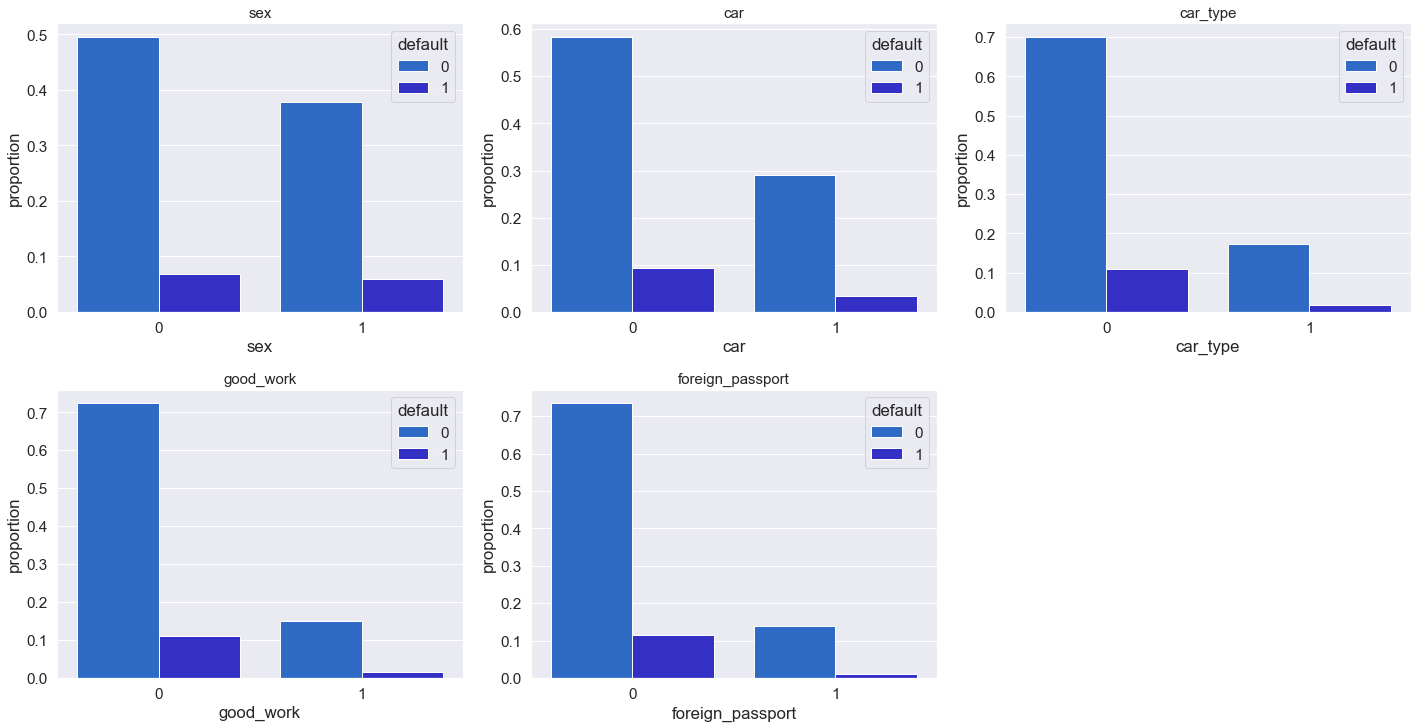

In [415]:
plt.figure(figsize=[20, 20])
i = 1

for k in bin_cols:
    plt.subplot(4, 3, i)
    sns.barplot(x=k,
                y='proportion',
                hue='default',
                data=train[[k, 'default']].value_counts(
                    normalize=True).rename('proportion').reset_index(),
                palette=[colors[3], colors[4]])
    plt.title(k, fontsize=15)
    i += 1
  
plt.tight_layout()
plt.show()


Значимость категориальных переменных

<AxesSubplot:>

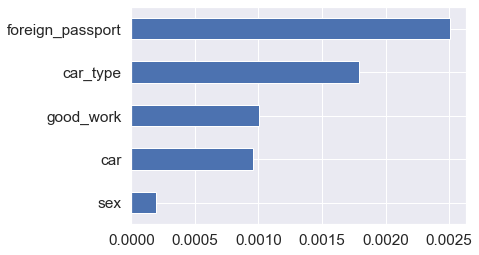

In [416]:
imp_cat = Series(mutual_info_classif(
    train[bin_cols], train['default'], discrete_features=True), index=bin_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

Наиболее значимыми признаками являются foreign_passport, car_type и good_work

### Теперь посмотрим на категориальные признаки.

In [417]:
train[cat_cols].head()

,education,home_address,work_address,sna,first_time
0,SCH,1,2,4,1
1,SCH,2,3,4,1
2,SCH,1,2,1,4
3,SCH,2,3,1,3
4,GRD,2,3,1,4


Заменим значения в признаке education

In [418]:
education_dict = {'SCH':1, 'GRD':2, 'UGR':3, 'PGR':4, 'ACD':5}
train['education'] = train['education'].replace(to_replace=education_dict)
test['education'] = test['education'].replace(to_replace=education_dict)

<AxesSubplot:>

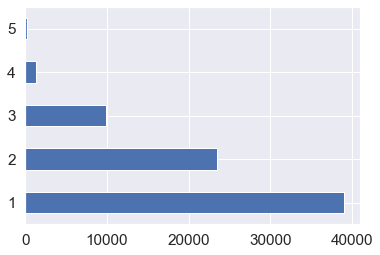

In [419]:
train.education.value_counts().plot.barh()

In [420]:
train['age_cat'] = 0 # create age_categorical column
train['age_cat'] = train['age'].apply(lambda x:age_to_cat(x))
train = train.drop('age',axis=1)

test['age_cat'] = 0 # create age_categorical column
test['age_cat'] = test['age'].apply(lambda x:age_to_cat(x))
test = test.drop('age',axis=1)

In [421]:
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

cat_cols = ['education', 'home_address', 'work_address', 'sna', 'first_time', 'age_cat']

num_cols = ['decline_app_cnt', 'region_rating',
            'income', 'bki_request_cnt', 'score_bki']

Теперь посмотрим на графики категориальных переменных

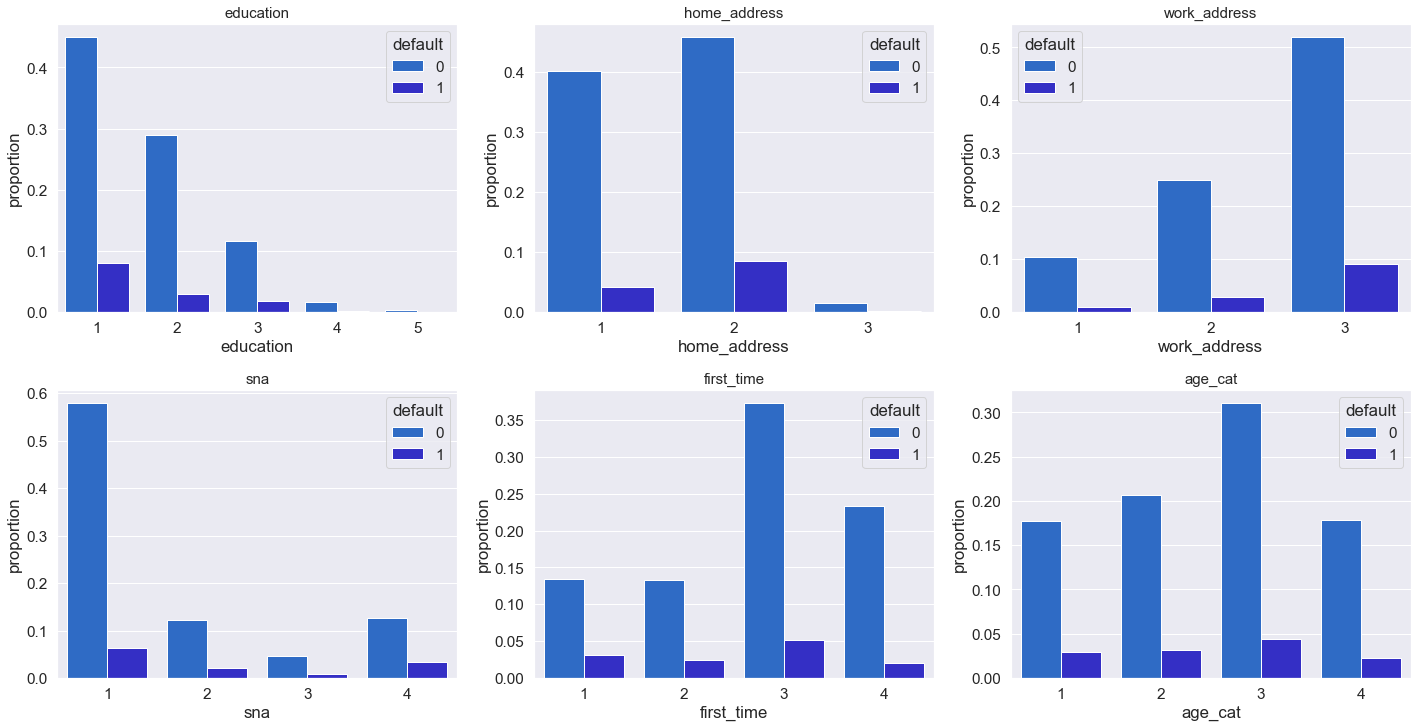

In [422]:
plt.figure(figsize=[20, 20])
i = 1

for k in cat_cols:
    plt.subplot(4, 3, i)
    sns.barplot(x=k,
                y='proportion',
                hue='default',
                data=train[[k, 'default']].value_counts(
                    normalize=True).rename('proportion').reset_index(),
                palette=[colors[3], colors[4]])
    plt.title(k, fontsize=15)
    i += 1
  
plt.tight_layout()
plt.show()

Посмотрим корреляционную матрицу признаков

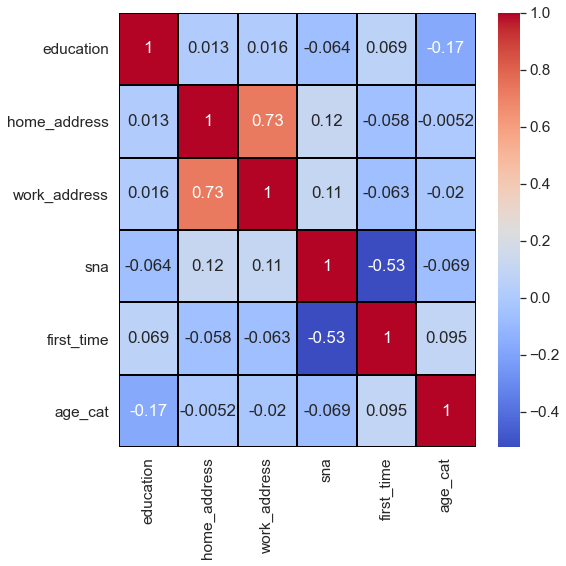

In [423]:
sns.heatmap(train[cat_cols].corr(),annot = True, cmap = 'coolwarm',
            linewidths=1, linecolor='black')
fig = plt.gcf()
fig.set_size_inches(8,8)

Есть прямая корреляция между признаками work_address и home_address. Можно удалить один из признаков или сгенерировать новый.

Значимость категориальных переменных

<AxesSubplot:>

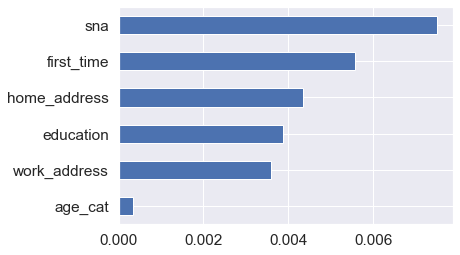

In [424]:
imp_cat = Series(mutual_info_classif(
    train[cat_cols], train['default'], discrete_features=True), index=cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

Наиболее значимыми признаками являются sna, first_time и home_address.

С признаком first_time поработаем чуть позже.

### Числовые переменные

Посмотрим на нашу целевую переменную

<AxesSubplot:>

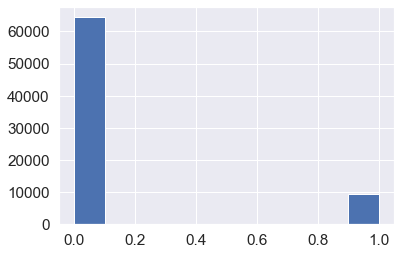

In [425]:
train.default.hist()

Сразу можно заметить, что классы несбалансированы.

Посмотрим на графики числовых признаков.

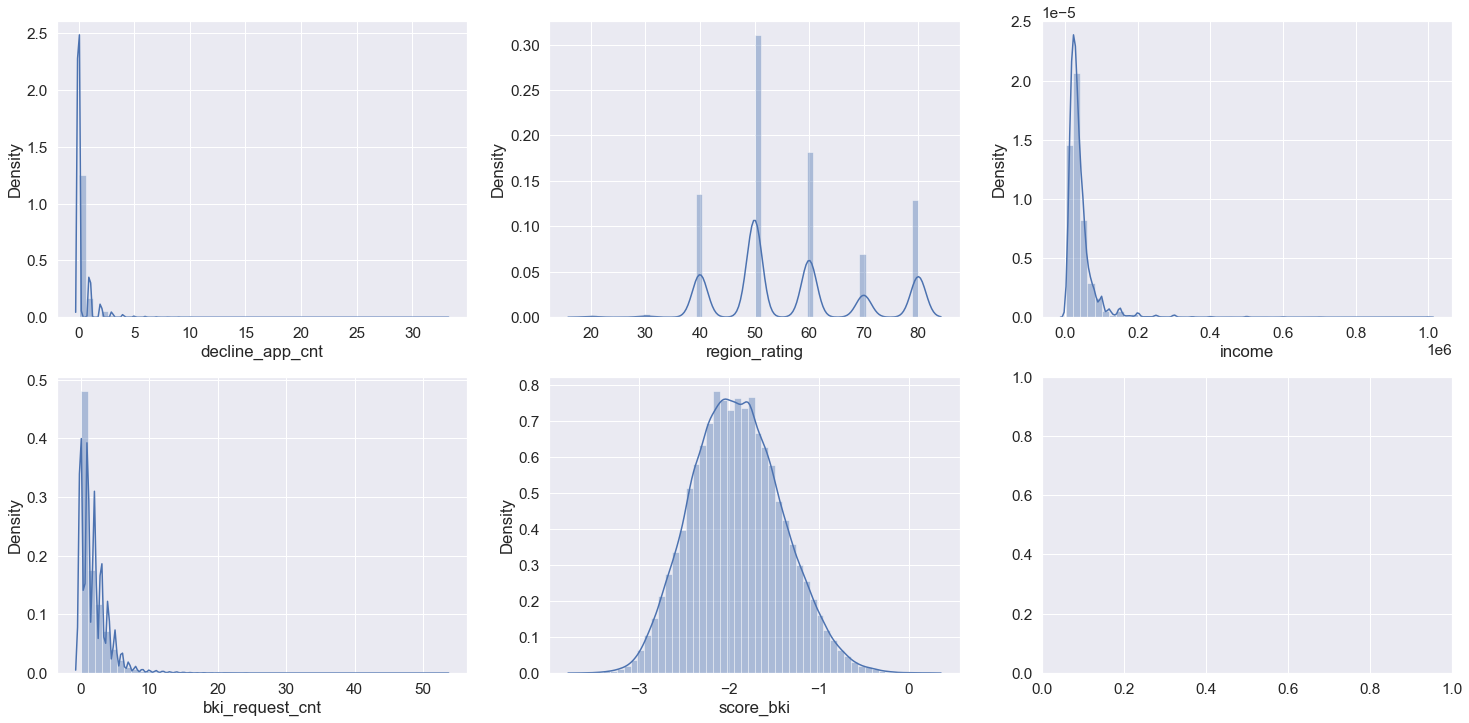

In [426]:
fig, axes = plt.subplots(2, 3, figsize=(25,12))
for col, i in zip(num_cols, range(6)):
    sns.distplot(train[col], ax=axes.flat[i])

In [427]:
for i in ['decline_app_cnt', 'bki_request_cnt', 'income']:
    train[i] = np.log(train[i] + 1)

Посмотрим на матрицу корреляций

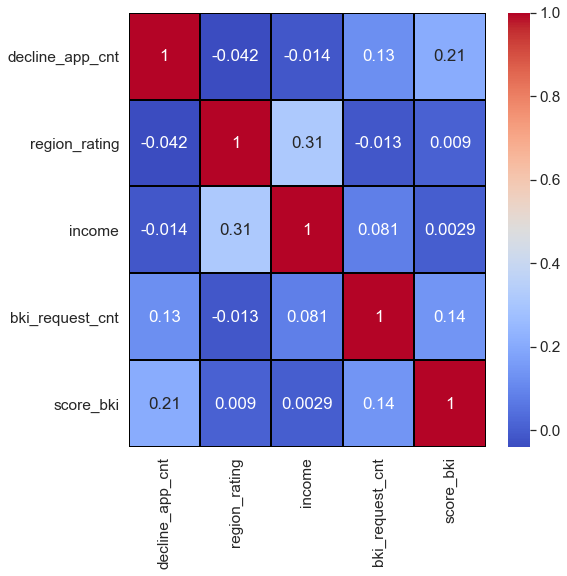

In [428]:
sns.heatmap(train[num_cols].corr(),annot = True, cmap = 'coolwarm',
            linewidths=1, linecolor='black')
fig = plt.gcf()
fig.set_size_inches(8,8)

Из матрицы видно, что между числовыми признаками нет сильной корреляции.

### Значимость непрерывных переменных

<AxesSubplot:>

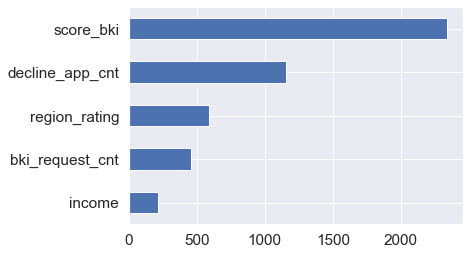

In [429]:
imp_num = pd.Series(f_classif(train[num_cols], train['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

## Дата

In [430]:
train.app_date.head()

0    01FEB2014
1    12MAR2014
2    01FEB2014
3    23JAN2014
4    18APR2014
Name: app_date, dtype: object

Приведем признак к формату datatime

In [431]:
train['app_date'] = train['app_date'].apply(lambda x: datetime.strptime(x, '%d%b%Y'))
test['app_date'] = test['app_date'].apply(lambda x: datetime.strptime(x, '%d%b%Y'))

Создадим новый признак - количество дней прошедшее от даты подачи заявки до сегодняшнего дня

In [432]:
today = datetime.now()

train['days'] = (today - train.app_date).dt.days
test['days'] = (today - test.app_date).dt.days

num_cols.append('days')

In [433]:
train['days'].head()

0    2725
1    2686
2    2725
3    2734
4    2649
Name: days, dtype: int64

In [434]:
test['days'].head()

0    2676
1    2733
2    2675
3    2723
4    2722
Name: days, dtype: int64

### Подготовка данных к машинному обучению

Для начала уберем признаки, которые коррелируют между собой - car и work_address

In [435]:
bin_cols = ['car_type', 'good_work', 'foreign_passport']

cat_cols = ['education', 'home_address', 'sna', 'first_time','age_cat']

num_cols = ['decline_app_cnt', 'bki_request_cnt', 'days', 'region_rating',
            'income','score_bki'] 

Воспользуемся методом One-Hot Encoding для преобразования категориальных признаков

In [436]:
X_cat = OneHotEncoder(sparse = False).fit_transform(train[cat_cols].values)
XX_cat = OneHotEncoder(sparse = False).fit_transform(test[cat_cols].values)

Воспользуемся методом StandardScaler для преобразования числовых признаков

In [437]:
X_num = StandardScaler().fit_transform(train[num_cols].values)
XX_num = StandardScaler().fit_transform(test[num_cols].values)

In [438]:
X = np.hstack([X_num, train[bin_cols].values, X_cat])
Y = train['default'].values

In [439]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42,shuffle=True)

## Поиск опримальных значений гиперпараметров

In [440]:
# Сетка параметров
C = [0.1, 1, 10]
penalty = ['l2']
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
class_weight = ['balanced', {1:0.7, 0:0.3}]

param = dict(penalty=penalty, solver=solver, class_weight=class_weight, C=C)


model = LogisticRegression()
model.fit(X_train, y_train)

gridsearch = GridSearchCV(model, param_grid=param, scoring='f1', n_jobs=-1, cv=5)
grid_result = gridsearch.fit(X_train, y_train)

# Печать лучших параметров
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Best Score:  0.33743611257804684
Best Params:  {'C': 1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'newton-cg'}


## Обучение модели

In [441]:
model = LogisticRegression(C=1, class_weight='balanced', penalty='l2', solver='newton-cg')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

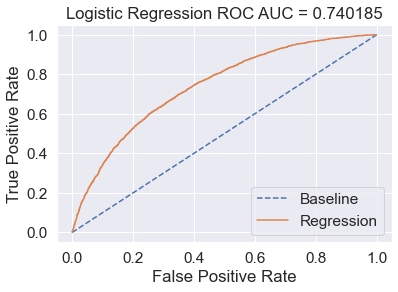

In [442]:
probs = model.predict_proba(X_test)
probs = probs[:,1]

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.6f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

<AxesSubplot:>

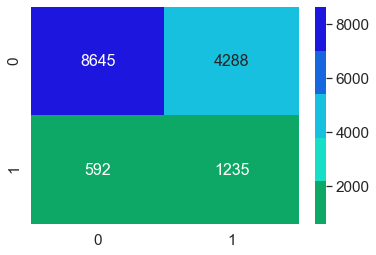

In [443]:
# Посмотрим на результат тренировки модели с помощью Confusion Matrix
conf_mat = confusion_matrix(y_test,  y_pred)

sns.set(font_scale=1.4) # for label size
sns.heatmap(conf_mat, annot=True, annot_kws={"size": 16}, fmt='g', cmap=colors)

In [444]:
X_test1 = np.hstack([XX_num, test[bin_cols].values, XX_cat])

y_probs = model.predict_proba(X_test1)[:,1]

test['default'] = y_probs
submission = test[['client_id','default']]
display(submission.sample(10))
display(submission.shape)

submission.to_csv('submission.csv', index=False)

,client_id,default
20383,101329,0.329943
5155,6072,0.310237
5690,81871,0.657252
12092,96241,0.531874
3139,61613,0.324154
36343,72405,0.638128
2331,16003,0.947303
35925,56002,0.411571
10498,314,0.594470
26007,54440,0.758901


(36349, 2)